In [1]:
!pip install datasets

In [2]:
import torch
from torch.utils.data import Dataset
from datasets import load_dataset
from transformers import AutoTokenizer
from nltk.tokenize import word_tokenize

class IMDBDataset(Dataset):
    def __init__(self, split: str = "train"):
        super(IMDBDataset, self).__init__()
        self.dataset = load_dataset("imdb", split=split)
        self.reviews = self.dataset['text']
        self.classes = self.dataset['label']
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Load tokenizer once

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx: int):
        tokens = self.tokenizer(self.reviews[idx], padding="max_length", truncation=True, max_length=512, return_tensors="pt")

        return {
            'review': tokens["input_ids"].squeeze(0),  # Remove batch dim (1,512) → (512)
            'attention_mask': tokens["attention_mask"].squeeze(0),
            'label': self.classes[idx]
        }


In [3]:
!pip install nltk

In [4]:
import torch

def save_checkpoint(model, optimizer, scheduler, epoch, filename):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
    }
    
    if isinstance(scheduler, torch.optim.lr_scheduler.LambdaLR):
        checkpoint["scheduler_params"] = {
            "d_model": scheduler.d_model,
            "warmup_steps": scheduler.warmup_steps
        }

    torch.save(checkpoint, filename)

    
def load_checkpoint(filename, model, optimizer, scheduler=None):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    
    if scheduler and "scheduler_params" in checkpoint:
        scheduler = TransformerScheduler(optimizer, **checkpoint["scheduler_params"])
    
    return checkpoint.get("epoch", 0), scheduler


In [5]:
import matplotlib.pyplot as plt

def plot_metrics(val_losses, val_accuracies):
    # Plot Training and Validation Loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)  # Create subplot for loss
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Progress')
    
    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)  # Create subplot for accuracy
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Progress')
    
    # Show the plots
    plt.tight_layout()
    plt.show()


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from tqdm import tqdm

class TransformerScheduler(torch.optim.lr_scheduler.LambdaLR):
    def __init__(self, optimizer, d_model, warmup_steps=4000):
        self.d_model = d_model
        self.warmup_steps = warmup_steps

        # Define lr_lambda as a function first
        def lr_lambda(step):
            step = max(1, step)
            return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))

        # Now call the parent constructor with the properly defined function
        super().__init__(optimizer, lr_lambda)


def compute_accuracy(preds, labels):
    # Get predicted class (index of the max logit)
    preds = torch.argmax(preds, dim=1)  
    
    # Compare with true labels and calculate accuracy
    correct = (preds == labels).sum().item()
    total = labels.size(0)

    return correct / total

def validate(
    model: torch.nn.Module,
    validloader: DataLoader,
    criterion: torch.nn.Module,
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
) -> tuple:
    model.to(device)
    model.eval()

    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        loop = tqdm(validloader, desc="Validating", leave=True)

        for batch in loop:
            # Fetch inputs and targets from the batch
            review, label = batch["review"].to(device), batch["label"].to(device)

            # Forward pass through the model
            pred = model(review)

            # Compute the loss
            loss = criterion(pred, label)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(pred, dim=1)
            correct_predictions += (predicted == label).sum().item()
            total_predictions += label.size(0)

            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(validloader)
    accuracy = correct_predictions / total_predictions

    return avg_loss, accuracy

def train(
    model: nn.Module,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    scheduler: optim.lr_scheduler._LRScheduler,
    trainloader: DataLoader,
    validloader: DataLoader,
    epochs: int,
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
) -> None:
    model.to(device)
    model.train()

    total_losses = []
    total_accs = []
    best_accuracy = 0.0

    for epoch in range(epochs):
        loop = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        total_loss = 0.0

        for batch in loop:
            # Fetch inputs and targets from the batch
            review, label = batch["review"].to(device), batch["label"].to(device)

            optimizer.zero_grad()

            # Forward pass through the model
            pred = model(review)

            # Compute the loss
            loss = criterion(pred, label)  # Compare with label
            loss.backward()

            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / len(trainloader)
        avg_val_loss, val_accuracy = validate(model, validloader, criterion, device)
        total_losses.append(avg_val_loss)
        total_accs.append(val_accuracy)
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")

        if val_accuracy > best_accuracy:
            save_checkpoint(model, optimizer, scheduler, epoch, filename=f"checkpoint_{epoch}.pth")
            best_accuracy = val_accuracy

    plot_metrics(total_losses, total_accs)


In [7]:
import torch.nn as nn
import torch.nn.functional as F
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Positional Encoding (to add order information to token embeddings)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]  # Add positional encoding to input embeddings


# Multi-Head Self Attention Mechanism
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        self.qkv_proj = nn.Linear(d_model, d_model * 3)
        self.out_proj = nn.Linear(d_model, d_model)
        self.scale = math.sqrt(self.head_dim)

    def forward(self, x, mask=None):
        B, T, C = x.shape  # Batch, Time (seq_len), Channels (d_model)
        qkv = self.qkv_proj(x).chunk(3, dim=-1)  # Split into Q, K, V
        q, k, v = [t.view(B, T, self.num_heads, self.head_dim).transpose(1, 2) for t in qkv]

        attn_scores = (q @ k.transpose(-2, -1)) / self.scale  # Scaled dot-product attention
        attn_probs = F.softmax(attn_scores, dim=-1)
        attn_output = (attn_probs @ v).transpose(1, 2).contiguous().view(B, T, C)

        return self.out_proj(attn_output)


# Feed Forward Network (MLP inside Transformer Block)
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.fc2(F.gelu(self.fc1(x)))


# Transformer Encoder Block (Self-Attention + FFN)
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = x + self.dropout(self.self_attn(self.norm1(x), mask))
        x = x + self.dropout(self.ffn(self.norm2(x)))
        return x


# Full Transformer Encoder Model for Sentiment Analysis
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model=768, num_heads=12, num_layers=6, d_ff=3072, max_len=512, num_classes=2):
        super(TransformerEncoder, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.encoder_layers = nn.ModuleList([TransformerEncoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, num_classes)  # Classification head

    def forward(self, x, mask=None):
        x = self.token_embedding(x)
        x = self.pos_encoding(x)
        for layer in self.encoder_layers:
            x = layer(x, mask)
        x = self.norm(x)  # Final layer norm
        x = x.mean(dim=1)  # Average pooling over tokens
        return self.fc(x)  # Logits for classification


In [8]:
vocab_size = 30522  # Standard BERT tokenizer vocab size
model = TransformerEncoder(vocab_size=vocab_size, d_model=768, num_heads=12, num_layers=6, d_ff=3072, num_classes=2).to("cuda")

In [9]:
# Some Hyperparameters
EPOCHS = 5
LR = 1e-4
BATCH_SIZE = 32

trainset = IMDBDataset("train")
validset = IMDBDataset("test")

from torch.utils.data import DataLoader
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True)

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Validating: 100%|██████████| 782/782 [04:04<00:00,  3.20it/s, loss=0.816]


Epoch 1: Train Loss = 0.5873, Val Loss = 0.4744, Val Accuracy = 0.7713


Validating: 100%|██████████| 782/782 [04:04<00:00,  3.20it/s, loss=0.554]


Epoch 3: Train Loss = 0.3651, Val Loss = 0.3726, Val Accuracy = 0.8329


Validating: 100%|██████████| 782/782 [04:04<00:00,  3.20it/s, loss=0.741]


Epoch 4: Train Loss = 0.3395, Val Loss = 0.3647, Val Accuracy = 0.8379


Validating: 100%|██████████| 782/782 [04:04<00:00,  3.20it/s, loss=0.239]


Epoch 5: Train Loss = 0.2977, Val Loss = 0.3499, Val Accuracy = 0.8434


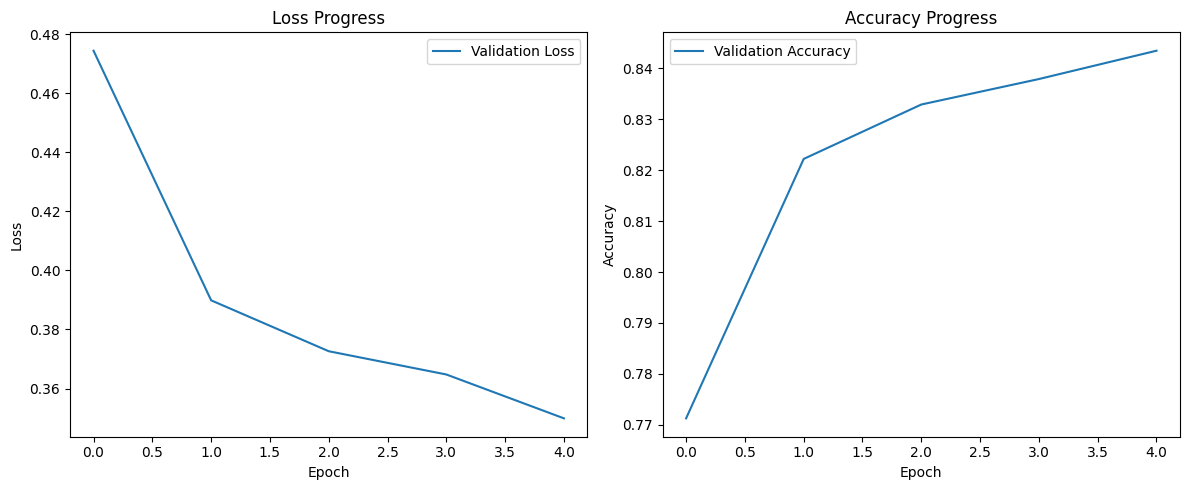

In [11]:
train(model, criterion, optimizer, TransformerScheduler, trainloader, validloader, EPOCHS)

In [12]:
def predict(model, tokenizer, review, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()  # Set model to evaluation mode
    model.to(device)

    # Tokenize input text
    tokens = tokenizer(review, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    input_ids = tokens["input_ids"].to(device)
    attention_mask = tokens["attention_mask"].to(device)

    # Forward pass
    with torch.no_grad():
        logits = model(input_ids)

    # Get prediction
    predicted_class = torch.argmax(logits, dim=1).item()
    
    # Convert to human-readable label
    sentiment = "Positive" if predicted_class == 1 else "Negative"
    
    print(f"Review Sentiment: {sentiment}")


In [15]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
predict(model, tokenizer, "This movie is very bad I like so much")

Review Sentiment: Negative
